In [1]:
import os
import sys
import numpy as np
import pandas as pd
#import pickle
import dill as pickle # https://stackoverflow.com/questions/25348532/can-python-pickle-lambda-functions
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pyperclip
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from utils import pre_process_df
from custom_transformers.transformers import PreProcessingTransformer, DropColumnsTransformer, CustomImputer, variables_mapping

In [2]:
df_week0 = pd.read_csv(os.path.join("data", "train_data.csv"))
df_week1 = pd.read_csv(os.path.join("data", "week1_raw.csv"))

# Convert the target variable into a boolean
df_week0['readmitted'] = df_week0['readmitted'] == 'Yes'

# Make all the variables dtype match
df_week1['admission_id'] = df_week1['admission_id'].astype('int64')
df_week1['patient_id'] = df_week1['patient_id'].astype('int64')
df_week1 = df_week1.drop('id', axis=1)

In [3]:
df_week0.shape

(81412, 34)

In [4]:
df_week1.shape

(9494, 34)

In [5]:
df_unbalanced = pd.concat([df_week0, df_week1])

In [6]:
df_unbalanced.shape

(90906, 34)

### Balance data

In [7]:
df_readmitted = df_unbalanced[df_unbalanced.readmitted == True]

In [8]:
readmitted_count = df_readmitted.shape[0]
total_count = df_unbalanced.shape[0]

print("There are " + str(total_count) + " observations, only " + str(readmitted_count) + " are readmitted")

There are 90906 observations, only 10146 are readmitted


In [9]:
(total_count - readmitted_count) / readmitted_count

7.959787108219988

In [10]:
# Add the readmitted subset 8 times to the original dataset
df_balanced = pd.concat([
    df_unbalanced, 
    df_readmitted, df_readmitted, df_readmitted, df_readmitted, df_readmitted, df_readmitted, df_readmitted
])

In [11]:
df_balanced.shape

(161928, 34)

In [12]:
readmitted_count = df_balanced[df_balanced.readmitted == True].shape[0]
total_count = df_balanced.shape[0]

print('The readmitted representativity is now ' + str(readmitted_count / total_count))

The readmitted representativity is now 0.5012598191788943


In [13]:
df = df_balanced

### Train/Test split

In [14]:
ordered_columns = ['admission_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed']

In [15]:
def create_target(df):
    X = df[ordered_columns]
    y = df['readmitted']
    
    return X, y

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['readmitted'], random_state=42)

X_train, y_train = create_target(df_train)
X_test, y_test = create_target(df_test)

### Modelling

In [17]:
#df_preprocessed = pre_process_df(df)

In [18]:
#Logistic regression - LogisticRegression
#Stochastic gradient descent
#Random forest
#Gradient boosting classifier
categorical_features = [
    'race',
    'gender',
    'admission_type_code',
    'discharge_disposition_code',
    'admission_source_code',
    'payer_code',
    'medical_specialty',
    'complete_vaccination_status',
    'diag_1',
    'diag_2',
    'diag_3',
    'blood_type'
]

numerical_features = [
    #'admission_id',
    #'patient_id',
    'age',
    #'weight',
    'time_in_hospital',
    'has_prosthesis',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'hemoglobin_level',
    'blood_transfusion',
    #'max_glu_serum',
    'A1Cresult',
    'diuretics',
    #'insulin',
    'change',
    'diabetesMed'
]


pre_process_pipeline = make_pipeline(
    PreProcessingTransformer(),
    DropColumnsTransformer(),
    CustomImputer(),  
    #OneHotEncoder(handle_unknown='ignore'),
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
    )
)


pipeline = make_pipeline(
    pre_process_pipeline,
    #LogisticRegression(random_state=42)
    #RandomForestClassifier(random_state=42, max_depth=3, n_estimators=25)
    #SGDClassifier(random_state=42, loss = 'log')
    GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.3,
        max_depth=10,   
        min_samples_leaf=100,
        min_samples_split=125
    )
    #LogisticRegression(random_state=42)
)

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessingtransformer',
                                  <custom_transformers.transformers.PreProcessingTransformer object at 0x1119ee990>),
                                 ('dropcolumnstransformer',
                                  <custom_transformers.transformers.DropColumnsTransformer object at 0x1307ff650>),
                                 ('customimputer',
                                  <custom_transformers.transformers.CustomImputer object at 0x1307ff690>),
                                 ('column...
                                                                   ['race',
                                                                    'gender',
                                                                    'admission_type_code',
                                                                    'discharge_disposition_code',
                                                                    '

### Evaluate the model

In [20]:
y_pred_train = pipeline.predict_proba(X_train)[:,1]
y_pred_test = pipeline.predict_proba(X_test)[:,1]

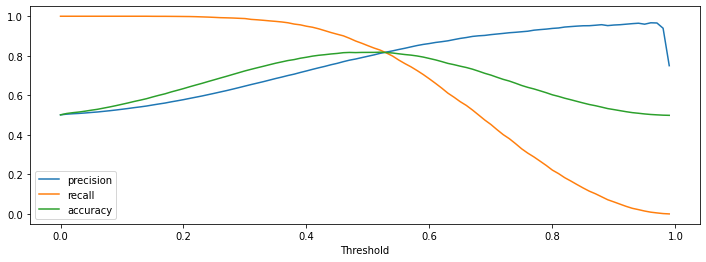

In [21]:
def plot_precision_recall_evolution():
    precision = []
    recall = []
    accuracy = []
    
    thresholds = []
    lim = []


    for i in range(100):
        current_threshold = i / 100

        thresholds.append(current_threshold)
        best_preds = y_pred_test > current_threshold

        precision.append(precision_score(y_true=y_test, y_pred=best_preds, pos_label=True))
        recall.append(recall_score(y_true=y_test, y_pred=best_preds, pos_label=True))
        accuracy.append(accuracy_score(y_true=y_test, y_pred=best_preds))
        
        lim.append(0.5)
    

    plt.plot(thresholds, precision, label='precision')
    plt.plot(thresholds, recall, label='recall')
    plt.plot(thresholds, accuracy, label='accuracy')
    #plt.plot(thresholds, lim, label='lim')

    plt.xlabel('Threshold');
    plt.legend()

    plt.gcf().set_size_inches(12,4)
    plt.gcf().savefig("images/precision_recall_evolution.pdf")

    plt.show()

plot_precision_recall_evolution()

In [22]:
def find_best_threshold(preds_proba, y_test, min_recall=0.5, min_precision=0.75):

    threshold = 0.5
    threshold_recall = 0
    threshold_precision = 0

    best_f1score = 0

    for i in range(100):
        current_threshold = i / 100

        best_preds = preds_proba > current_threshold
        
        precision = precision_score(y_test, best_preds) #, pos_label=True)
        recall = recall_score(y_test, best_preds)
        
        f1score = f1_score(y_test, best_preds)
        accuracy = accuracy_score(y_true=y_test, y_pred=best_preds)
        
        if recall >= min_recall and precision >= min_precision and recall > threshold_recall:
            threshold = current_threshold
            threshold_recall = recall
            threshold_precision = precision
            threshold_accuracy = accuracy
        
        if f1score > best_f1score:
            best_f1score = f1score
            
    return threshold, threshold_precision, threshold_recall, best_f1score, threshold_accuracy

In [23]:
threshold_train, precision_train, recall_train, f1_train, accuracy_train = find_best_threshold(y_pred_train, y_train)
threshold_test, precision_test, recall_test, f1_test, accuracy_test = find_best_threshold(y_pred_test, y_test)

In [24]:
(threshold_train, precision_train, recall_train, f1_train, accuracy_train)

(0.38,
 0.7508121197802847,
 0.9788400529768688,
 0.8766536849302851,
 0.8265504623982955)

In [25]:
(threshold_test, precision_test, recall_test, f1_test, accuracy_test)

(0.44,
 0.754750443374715,
 0.9175187877294567,
 0.8304704579654184,
 0.8092076823318718)

### Export pipeline

In [26]:
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']

### Grid Search

In [27]:
grid_search_parameter_space = {
    'n_estimators': [100], 
    'learning_rate': [0.6, 1.3, 10],
    'max_depth': [10],
    'min_samples_leaf': [20, 50, 100],
    'min_samples_split': [20, 50, 100]
}

grid_search_parameter_space = {
    'n_estimators': [100], 
    'learning_rate': [0.6, 1.3, 10],
    'max_depth': [10],
    'min_samples_leaf': [20, 50, 100],
    'min_samples_split': [20, 50, 100]
}


In [28]:
grid_search = GridSearchCV(
                GradientBoostingClassifier(),
                grid_search_parameter_space,
                cv=5,
                scoring="f1",
                return_train_score=True
                )

In [29]:
X_train_preprocessed = pre_process_pipeline.fit_transform(X_train)

In [30]:
#grid_search.fit(X_train_preprocessed, y_train)

### Discrimination

In [31]:
def get_descrimination_dict(df_, sensitive_columns=['age', 'race', 'gender', 'is_insured', 'medical_specialty'], target='readmitted'):
    """ 
    """
    
    specialties = df_['medical_specialty'].unique()
        
    result = {}
    for sensitive_column in sensitive_columns:
        classes = sorted([ str(x) for x in df_[sensitive_column].unique() ])        
        
        result[sensitive_column] = {}
        #result[sensitive_column]['classes_order'] = classes # Preserve the order we iterate through sensitive class
        to_remove = ['Anesthesiology', 'Endocrinology', 'Gynecology/Obstetrics', 'Neurology', 'Ophthalmology', 'InfectiousDiseases', 'Podiatry', 'unknown']
        
        for class_ in classes:
            if class_ not in to_remove:
                medical_encounters = df_[(df_[sensitive_column] == class_)]

                y_true = medical_encounters.readmitted.astype(bool)
                y_pred = medical_encounters.prediction.astype(bool)

                precision = precision_score(y_true, y_pred, labels=[True])

                result[sensitive_column][class_] = precision
    
    return result

In [32]:
def plot_dict(D, name):
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))

    plt.ylabel("Precision - Readmission Rate")
    if name == 'medical_specialty':
        plt.gcf().set_size_inches(12,4)
        plt.xticks(rotation=90)
    else:
        plt.gcf().set_size_inches(6,4)
    
    plt.gcf().savefig("images/discrimination_requirement_" + sensitive_column + ".pdf")

    plt.show()

In [33]:
pre_process_pipeline.fit(X_train)

Pipeline(steps=[('preprocessingtransformer',
                 <custom_transformers.transformers.PreProcessingTransformer object at 0x1119ee990>),
                ('dropcolumnstransformer',
                 <custom_transformers.transformers.DropColumnsTransformer object at 0x1307ff650>),
                ('customimputer',
                 <custom_transformers.transformers.CustomImputer object at 0x1307ff690>),
                ('columntransformer',
                 ColumnTransform...
                                                   'number_diagnoses',
                                                   'hemoglobin_level',
                                                   'blood_transfusion',
                                                   'A1Cresult', 'diuretics',
                                                   'change', 'diabetesMed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore')

In [34]:
# Pre-process X_test and add extra columns for the discrimination analysis
X_test_preprocessed = pre_process_df(X_test)

X_test_preprocessed['prediction'] = y_pred_test >= 0.44
X_test_preprocessed['readmitted'] = y_test
X_test_preprocessed['is_insured'] = X_test_preprocessed.payer_code.fillna('BC').apply(lambda x: 'insured' if np.nan_to_num(x) == 'SP' else 'not insured').astype('category')
X_test_preprocessed['age'] = X_test_preprocessed.age.apply(lambda x: str(x)).astype('category')

dict_ = get_descrimination_dict(X_test_preprocessed)

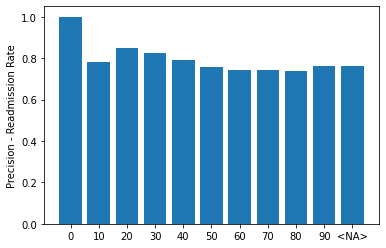

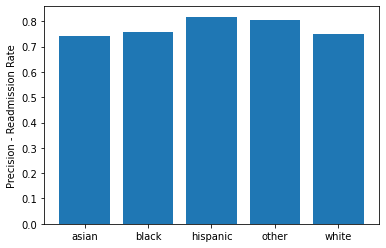

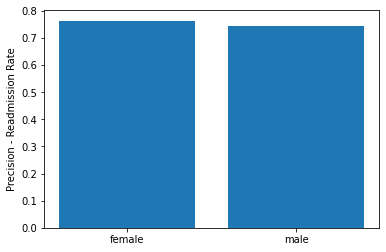

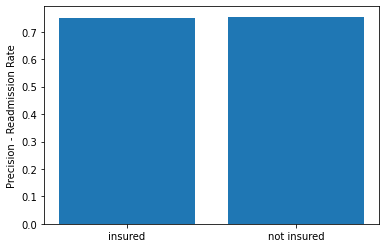

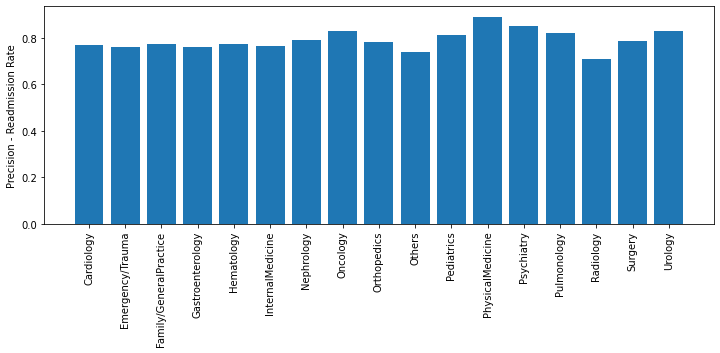

In [35]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    plot_dict(dict_[sensitive_column], sensitive_column)

In [36]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    values = dict_[sensitive_column].values()
    values = [ x for x in values if x != 0 and x != 1 and x != 0 ] # remove zeros and ones, because such precision score is due to scarce data
    
    min_ = min(values)
    max_ = max(values)
    print(sensitive_column + ' - ' + str(max_-min_))

age - 0.11121123526506194
race - 0.07481898632341111
gender - 0.018982199634234753
is_insured - 0.005575599022651034
medical_specialty - 0.18092621664050235


In [37]:
dict_

{'age': {'0': 1.0,
  '10': 0.7818181818181819,
  '20': 0.8509485094850948,
  '30': 0.8243045387994143,
  '40': 0.7918523233609166,
  '50': 0.7594119756185013,
  '60': 0.7434024505183789,
  '70': 0.7429590687194892,
  '80': 0.7397372742200329,
  '90': 0.7634194831013916,
  '<NA>': 0.764378478664193},
 'race': {'asian': 0.7433628318584071,
  'black': 0.7594637223974764,
  'hispanic': 0.8181818181818182,
  'other': 0.8060344827586207,
  'white': 0.7511372758897511},
 'gender': {'female': 0.7634609982208072, 'male': 0.7444787985865724},
 'is_insured': {'insured': 0.7494172494172494,
  'not insured': 0.7549928484399004},
 'medical_specialty': {'Cardiology': 0.7678571428571429,
  'Emergency/Trauma': 0.7597535934291582,
  'Family/GeneralPractice': 0.7743421052631579,
  'Gastroenterology': 0.7615384615384615,
  'Hematology': 0.7714285714285715,
  'InternalMedicine': 0.763771186440678,
  'Nephrology': 0.7893569844789357,
  'Oncology': 0.8260869565217391,
  'Orthopedics': 0.7823834196891192,
  '